In [ ]:
!pip install transformers datasets torch scikit-learn matplotlib seaborn

In [ ]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from sklearn.metrics import classification_report
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

In [ ]:
# Load GoEmotions dataset
dataset = load_dataset("go_emotions", split="train")

In [ ]:
# Multi-hot encode labels
def create_multi_hot_label(labels, num_classes=28):
    multi_hot = [0] * num_classes
    for label in labels:
        multi_hot[label] = 1
    return multi_hot

dataset = dataset.map(lambda x: {"multi_hot_labels": create_multi_hot_label(x["labels"], num_classes=28)})


In [ ]:
# Tokenize with RoBERTa tokenizer
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=128)

encoded_dataset = dataset.map(tokenize_function, batched=True)


In [ ]:
# Define RoBERTa-based model
class RoBERTaModel(nn.Module):
    def __init__(self, num_labels):
        super(RoBERTaModel, self).__init__()
        self.transformer = AutoModel.from_pretrained("roberta-base")
        self.fc1 = nn.Linear(self.transformer.config.hidden_size, 256)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, num_labels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        outputs = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]
        x = self.fc1(pooled_output)
        x = self.relu(x)
        x = self.dropout(x)
        logits = self.fc2(x)
        return self.sigmoid(logits)

In [ ]:
# Prepare data for training
encoded_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "multi_hot_labels"])
train_loader = torch.utils.data.DataLoader(encoded_dataset, batch_size=16, shuffle=True)  # Experiment with batch size


In [ ]:
# Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RoBERTaModel(num_labels=28).to(device)

criterion = nn.BCELoss()  # Binary cross-entropy loss for multi-label classification
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)  # Experiment with learning rate

# Implement Cosine Learning Rate Scheduler
epochs = 7  # Experiment with epochs
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_loader) * epochs)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Modified Training Loop with Accuracy and Loss Tracking
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    # Training
    model.train()
    total_loss = 0
    correct_train = 0
    total_train = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}")

    for batch in progress_bar:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["multi_hot_labels"].to(device).float()

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

        # Compute training accuracy
        preds = (outputs > 0.5).float()
        correct_train += (preds == labels).all(dim=1).sum().item()
        total_train += labels.size(0)

        progress_bar.set_postfix(loss=total_loss / len(progress_bar))

    train_losses.append(total_loss / len(train_loader))
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)
    print(f"Epoch {epoch + 1}: Training Loss = {train_losses[-1]:.4f}, Training Accuracy = {train_accuracy:.4f}")



Epoch 1: 100%|██████████| 2714/2714 [07:49<00:00,  5.78it/s, loss=0.108]


Epoch 1: Training Loss = 0.1085, Training Accuracy = 0.3144


Epoch 2: 100%|██████████| 2714/2714 [07:52<00:00,  5.74it/s, loss=0.0865]


Epoch 2: Training Loss = 0.0865, Training Accuracy = 0.4299


Epoch 3: 100%|██████████| 2714/2714 [07:52<00:00,  5.74it/s, loss=0.0756]


Epoch 3: Training Loss = 0.0756, Training Accuracy = 0.4959


Epoch 4: 100%|██████████| 2714/2714 [07:52<00:00,  5.74it/s, loss=0.0651]


Epoch 4: Training Loss = 0.0651, Training Accuracy = 0.5599


Epoch 5: 100%|██████████| 2714/2714 [07:52<00:00,  5.75it/s, loss=0.0557]


Epoch 5: Training Loss = 0.0557, Training Accuracy = 0.6212


Epoch 6: 100%|██████████| 2714/2714 [07:52<00:00,  5.74it/s, loss=0.0493]


Epoch 6: Training Loss = 0.0493, Training Accuracy = 0.6644


Epoch 7: 100%|██████████| 2714/2714 [07:52<00:00,  5.75it/s, loss=0.0463]

Epoch 7: Training Loss = 0.0463, Training Accuracy = 0.6844


In [ ]:
from torch.utils.data import DataLoader

val_loader = DataLoader(encoded_dataset, batch_size=16, shuffle=False)  # Assuming encoded_dataset is your validation data

In [ ]:
 # Validation

all_preds = []
all_labels = []

model.eval()
val_loss = 0
correct_val = 0
total_val = 0
with torch.no_grad():
  for batch in train_loader:
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["multi_hot_labels"].to(device).float()

    outputs = model(input_ids, attention_mask)
    val_loss += criterion(outputs, labels).item()

    preds = (outputs > 0.5).float()
    correct_val += (preds == labels).all(dim=1).sum().item()
    total_val += labels.size(0)

    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

# Convert accumulated predictions and labels to NumPy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

val_losses.append(val_loss / len(train_loader))
val_accuracy = correct_val / total_val
val_accuracies.append(val_accuracy)
print(f"Epoch {epoch + 1}: Validation Loss = {val_losses[-1]:.4f}, Validation Accuracy = {val_accuracy:.4f}")


Epoch 7: Validation Loss = 0.0377, Validation Accuracy = 0.7406


AssertionError: Mismatch in losses list length!

In [ ]:
# Compute classification metrics
report = classification_report(all_labels, all_preds, target_names=[f"Label {i}" for i in range(28)], output_dict=True)
print(classification_report(all_labels, all_preds, target_names=[f"Label {i}" for i in range(28)]))


              precision    recall  f1-score   support

     Label 0       0.90      0.91      0.91      4130
     Label 1       0.89      0.94      0.92      2328
     Label 2       0.82      0.80      0.81      1567
     Label 3       0.80      0.56      0.66      2470
     Label 4       0.86      0.71      0.78      2939
     Label 5       0.86      0.80      0.83      1087
     Label 6       0.89      0.61      0.72      1368
     Label 7       0.78      0.79      0.78      2191
     Label 8       0.84      0.71      0.77       641
     Label 9       0.84      0.54      0.66      1269
    Label 10       0.88      0.76      0.81      2022
    Label 11       0.81      0.65      0.72       793
    Label 12       0.88      0.63      0.74       303
    Label 13       0.84      0.66      0.74       853
    Label 14       0.90      0.89      0.90       596
    Label 15       0.97      0.93      0.95      2662
    Label 16       1.00      0.01      0.03        77
    Label 17       0.86    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Extract metrics for plotting
target_names = [f"Label {i}" for i in range(28)]
accuracies = [report[label]["f1-score"] for label in target_names]
precisions = [report[label]["precision"] for label in target_names]
recalls = [report[label]["recall"] for label in target_names]

# Emotion labels for display
emotion_labels = dataset.features["labels"].feature.names

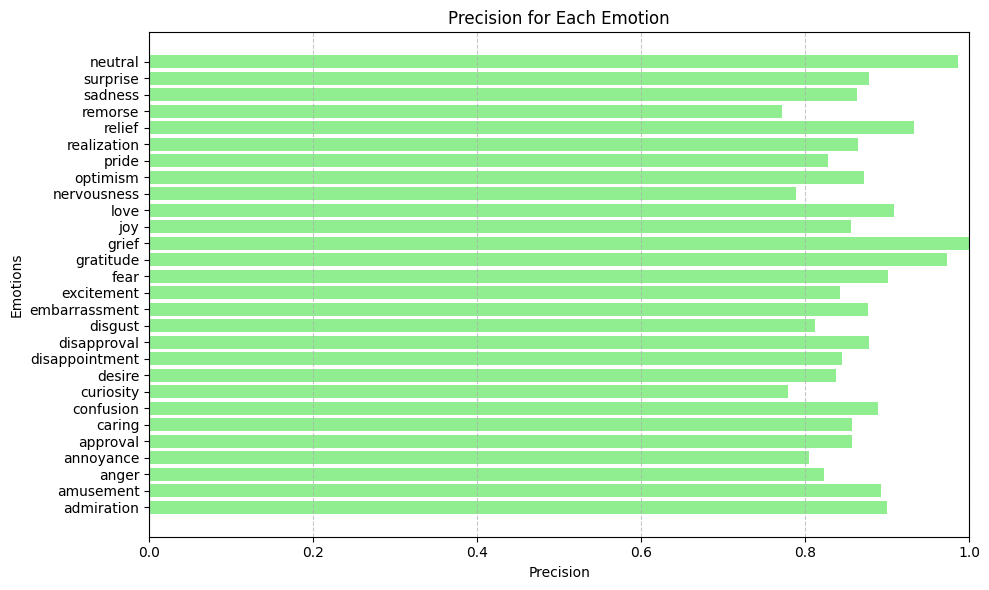

In [ ]:
# Precision graph
plt.figure(figsize=(10, 6))
plt.barh(emotion_labels, precisions, color="lightgreen")
plt.xlabel("Precision")
plt.ylabel("Emotions")
plt.title("Precision for Each Emotion")
plt.xlim(0, 1)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

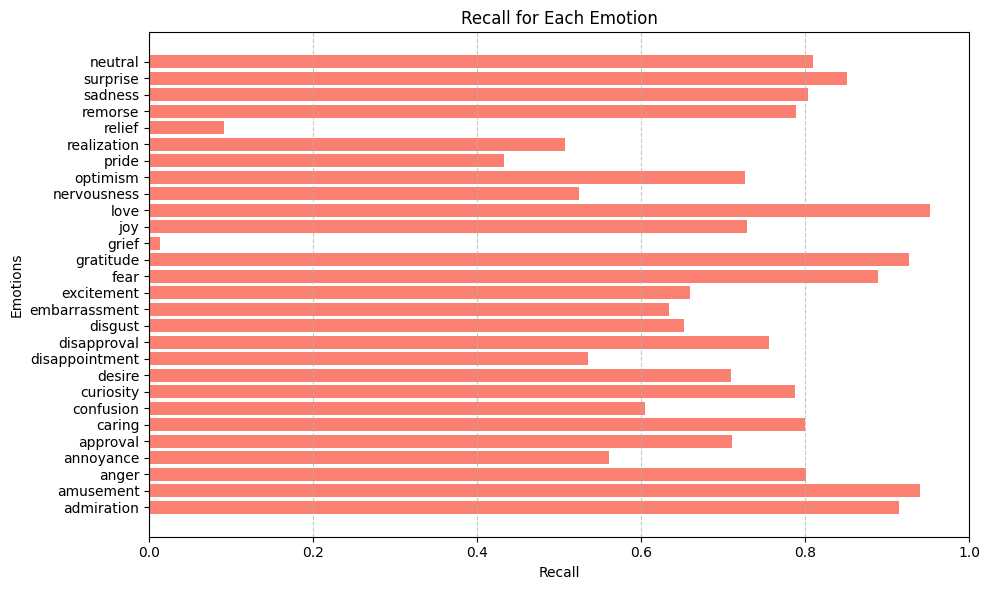

In [ ]:
# Recall graph
plt.figure(figsize=(10, 6))
plt.barh(emotion_labels, recalls, color="salmon")
plt.xlabel("Recall")
plt.ylabel("Emotions")
plt.title("Recall for Each Emotion")
plt.xlim(0, 1)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

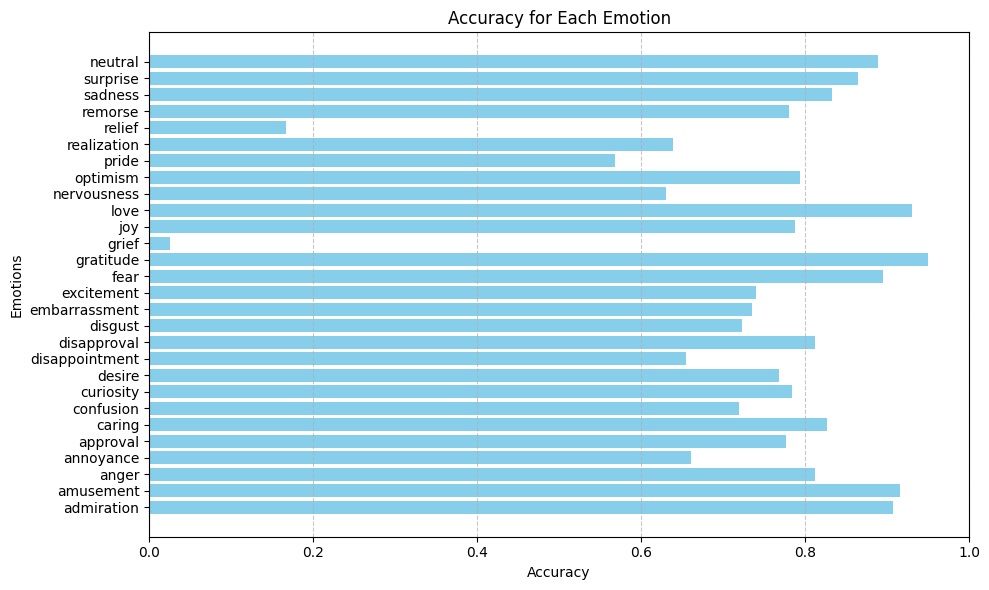

In [ ]:
# Accuracy graph
plt.figure(figsize=(10, 6))
plt.barh(emotion_labels, accuracies, color="skyblue")
plt.xlabel("Accuracy")
plt.ylabel("Emotions")
plt.title("Accuracy for Each Emotion")
plt.xlim(0, 1)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

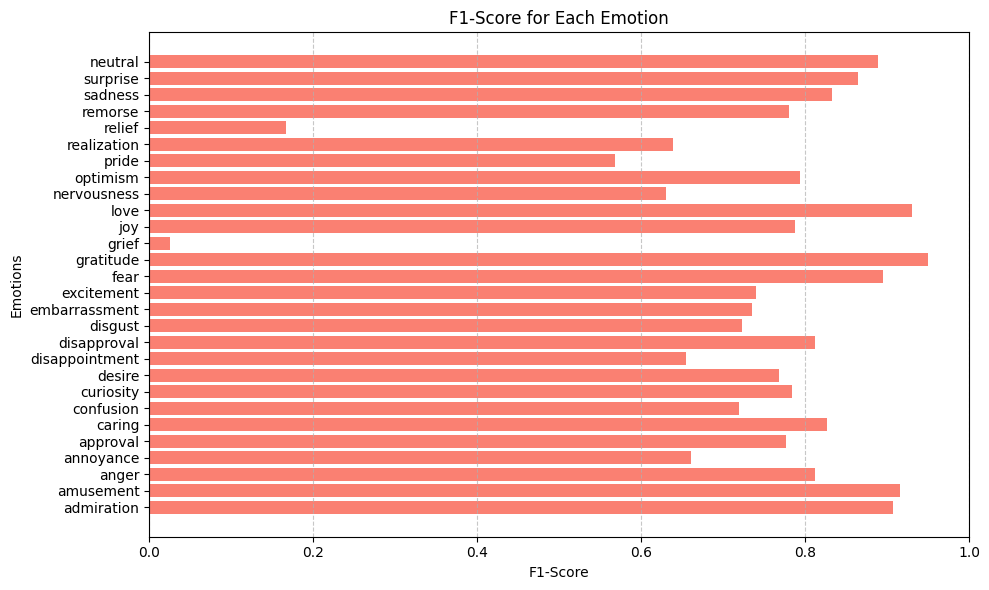

In [ ]:
import matplotlib.pyplot as plt

# Assuming accuracies, precisions, recalls, and emotion_labels are already extracted as above
# Extracting F1-scores from the classification report
f1_scores = [report[label]["f1-score"] for label in target_names]

# Plotting F1-scores for each emotion
plt.figure(figsize=(10, 6))
plt.barh(emotion_labels, f1_scores, color="salmon")
plt.xlabel("F1-Score")
plt.ylabel("Emotions")
plt.title("F1-Score for Each Emotion")
plt.xlim(0, 1)  # F1-scores range from 0 to 1
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

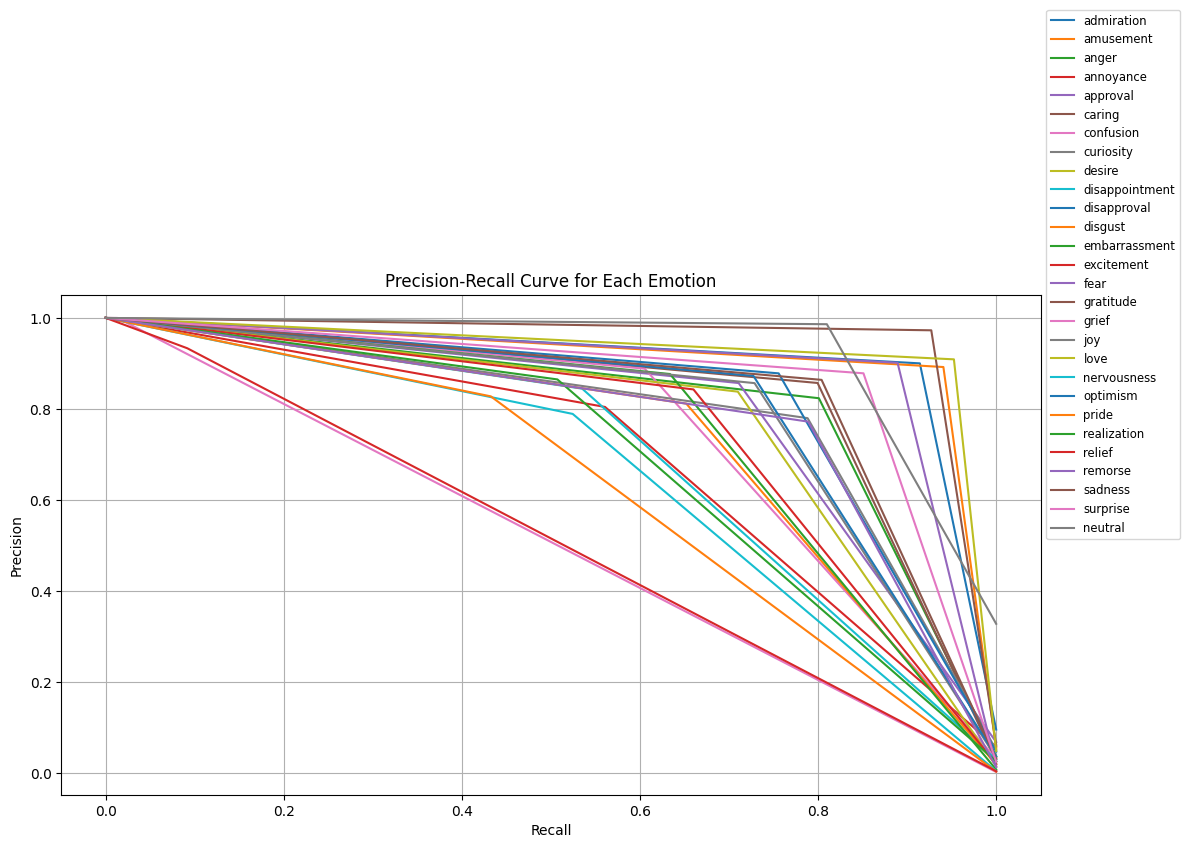

In [ ]:
# Precision-Recall Curves
y_true = np.array(all_labels)
y_pred = np.array(all_preds)

plt.figure(figsize=(12, 8))
for i, emotion in enumerate(emotion_labels):
    precision, recall, _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
    plt.plot(recall, precision, label=emotion)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Each Emotion")
plt.legend(loc="lower left", bbox_to_anchor=(1.0, 0.5), fontsize="small")
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
# Plot Training vs Validation Accuracy
assert len(train_accuracies) == len(val_accuracies), "Mismatch in accuracies list length!"
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Training Accuracy", marker="o")
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Validation Accuracy", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

AssertionError: Mismatch in accuracies list length!

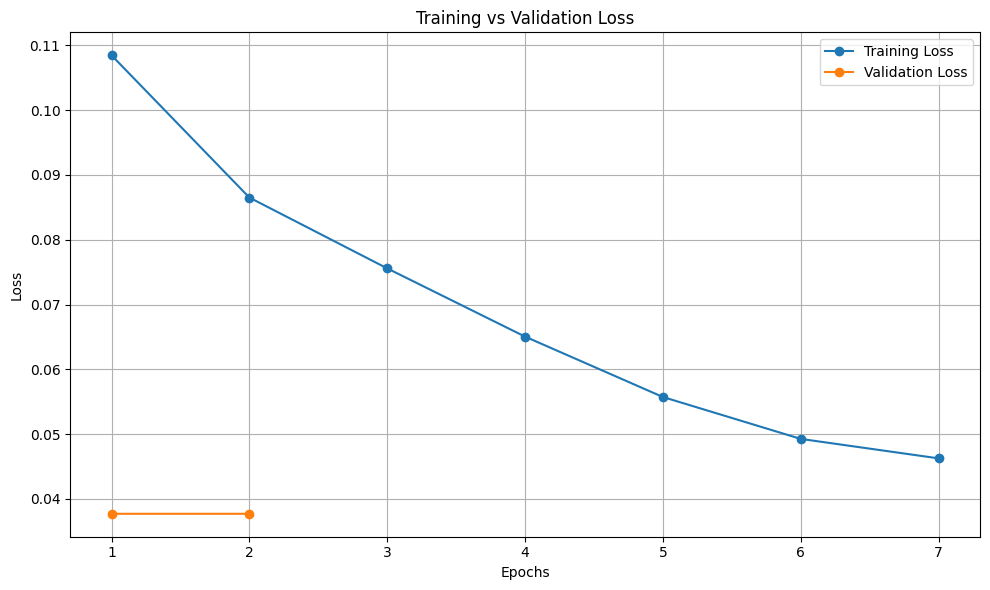

In [ ]:
# Plot Training vs Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss", marker="o")
# Adjusting x-axis range to match the length of val_losses
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
from transformers import AutoTokenizer
import os

# Define directories
MODEL_DIR = "/content/saved_model"
TOKENIZER_DIR = "/content/saved_tokenizer"

# Create directories if they don't exist
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(TOKENIZER_DIR, exist_ok=True)

# Save the model
torch.save(model.state_dict(), f"{MODEL_DIR}/model.pth")

# Save the tokenizer
tokenizer.save_pretrained(TOKENIZER_DIR)

print(f"Model saved to {MODEL_DIR}/model.pth")
print(f"Tokenizer saved to {TOKENIZER_DIR}")

Model saved to /content/saved_model/model.pth
Tokenizer saved to /content/saved_tokenizer


In [ ]:
from google.colab import files

# Download the model and tokenizer
#files.download(f"{MODEL_DIR}/model.pth")
!zip -r tokenizer.zip {TOKENIZER_DIR}
files.download("tokenizer.zip")

  adding: content/saved_tokenizer/ (stored 0%)
  adding: content/saved_tokenizer/tokenizer_config.json (deflated 76%)
  adding: content/saved_tokenizer/special_tokens_map.json (deflated 52%)
  adding: content/saved_tokenizer/tokenizer.json (deflated 82%)
  adding: content/saved_tokenizer/merges.txt (deflated 53%)
  adding: content/saved_tokenizer/vocab.json (deflated 59%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>